In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3530212e-629e-6d4a-0f29-4f05ee7e13e2)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip gdrive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("training_set"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'training_set'.
There are 2 directories and 0 images in 'training_set/training_set'.
There are 0 directories and 4001 images in 'training_set/training_set/cats'.
There are 0 directories and 4006 images in 'training_set/training_set/dogs'.


In [5]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("test_set"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'test_set'.
There are 2 directories and 0 images in 'test_set/test_set'.
There are 0 directories and 1012 images in 'test_set/test_set/cats'.
There are 0 directories and 1013 images in 'test_set/test_set/dogs'.


In [6]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

class_names = [ item for item in os.listdir('test_set/test_set') if os.path.isdir(os.path.join("test_set/test_set", item)) ]
print(class_names)

['cats', 'dogs']


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "training_set/training_set/"
test_dir = "test_set/test_set/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

test_data = valid_datagen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode="binary",
                                              seed=42)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [8]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [22]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [11]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [12]:
# Create model
resnet_model = create_model(resnet_url)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220610-060607
Epoch 1/5
251/251 [==============================] - 46s 158ms/step - loss: 0.1124 - accuracy: 0.9570 - val_loss: 0.0697 - val_accuracy: 0.9783
Epoch 2/5
251/251 [==============================] - 37s 147ms/step - loss: 0.0457 - accuracy: 0.9851 - val_loss: 0.0587 - val_accuracy: 0.9817
Epoch 3/5
251/251 [==============================] - 37s 146ms/step - loss: 0.0366 - accuracy: 0.9878 - val_loss: 0.0514 - val_accuracy: 0.9837
Epoch 4/5
251/251 [==============================] - 37s 146ms/step - loss: 0.0309 - accuracy: 0.9896 - val_loss: 0.0513 - val_accuracy: 0.9842
Epoch 5/5
251/251 [==============================] - 37s 146ms/step - loss: 0.0280 - accuracy: 0.9900 - val_loss: 0.0501 - val_accuracy: 0.9852


In [14]:
score = resnet_model.evaluate(test_data, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.05005146935582161
Validation accuracy: 0.9851705431938171


In [15]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

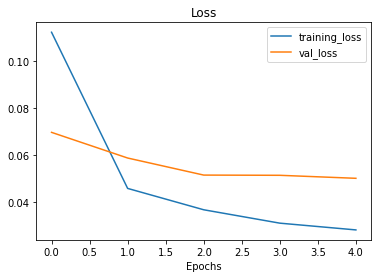

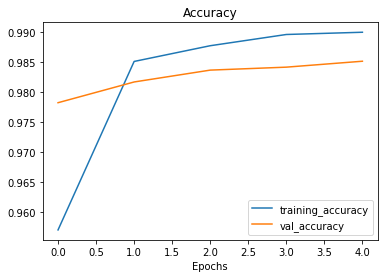

In [16]:
plot_loss_curves(resnet_history)

# Efficientnet Model

In [23]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220610-061721
Epoch 1/5
251/251 [==============================] - 44s 145ms/step - loss: 0.0000e+00 - accuracy: 0.5333 - val_loss: 0.0000e+00 - val_accuracy: 0.5106
Epoch 2/5
251/251 [==============================] - 35s 140ms/step - loss: 0.0000e+00 - accuracy: 0.5118 - val_loss: 0.0000e+00 - val_accuracy: 0.5106
Epoch 3/5
251/251 [==============================] - 36s 144ms/step - loss: 0.0000e+00 - accuracy: 0.5108 - val_loss: 0.0000e+00 - val_accuracy: 0.5106
Epoch 4/5
251/251 [==============================] - 35s 139ms/step - loss: 0.0000e+00 - accuracy: 0.5102 - val_loss: 0.0000e+00 - val_accuracy: 0.5101
Epoch 5/5
251/251 [==============================] - 35s 139ms/step - loss: 0.0000e+00 - accuracy: 0.5102 - val_loss: 0.0000e+00 - val_accuracy: 0.5091


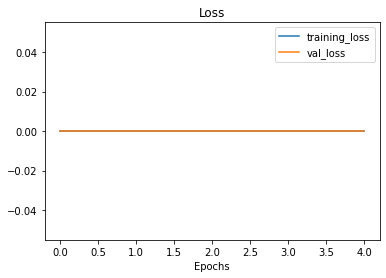

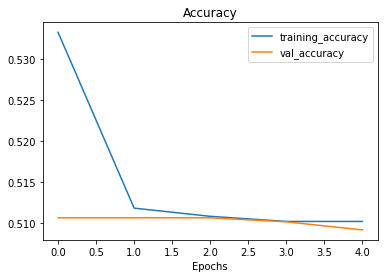

In [24]:
plot_loss_curves(efficientnet_history)